In [1]:
import pandas as pd
import numpy as np
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

### READ IN 2018 LPR FILE FOR INITIAL REVIEW
- found that top 4 rows in each file needed to be skipped, header reset
- verified that tail had no footnotes or other rows to delete
- need to add year column to each file before concat
- need to group classes of admission into 6 major categories as per government documentation: https://www.dhs.gov/immigration-statistics/lawful-permanent-residents/ImmigrantCOA
- need to fill D with value (non-disclosure "is used to conceal cells in frequency tabulations when counts are lower than 3 in order to minimize the risk that individuals can be identified" -- fill with 1 or 2 for avg? See: https://www.dhs.gov/disclosure-policy-office-immigration-statistics

In [145]:
lpr_2018 = pd.read_excel('../data/lpr_usa_counties_2018_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2018.shape)
lpr_2018.head()

(79514, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
0,California,Los Angeles,Afghanistan,Refugee and Asylee Adjustments,34
1,California,Los Angeles,Afghanistan,Other,234
2,California,Los Angeles,Afghanistan,Immediate Relatives - Spouses,6
3,California,Los Angeles,Afghanistan,Immediate Relatives - Parents,6
4,California,Los Angeles,Afghanistan,Family Preference 4th,D


In [3]:
lpr_2018.tail()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
79509,Texas,Ector,Vietnam,Immediate Relatives - Spouses,D
79510,Texas,Ector,Vietnam,Immediate Relatives - Parents,4
79511,Texas,Ector,Vietnam,Family Preference 4th,14
79512,Texas,Ector,Vietnam,Family Preference 2nd,D
79513,Texas,Ector,Zambia,Immediate Relatives - Children,D


 - replace D (see note at top) with 1
 - add year column for later merging purposes
 - change type from object to integer for calculation purposes

In [148]:
lpr_2018['Admissions'] = lpr_2018['Admissions'].replace(['D'], '1')
lpr_2018['Admissions'] = lpr_2018['Admissions'].astype(int)
lpr_2018['Year'] = 2018
lpr_2018.tail()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year
79509,Texas,Ector,Vietnam,Immediate Relatives - Spouses,1,2018
79510,Texas,Ector,Vietnam,Immediate Relatives - Parents,4,2018
79511,Texas,Ector,Vietnam,Family Preference 4th,14,2018
79512,Texas,Ector,Vietnam,Family Preference 2nd,1,2018
79513,Texas,Ector,Zambia,Immediate Relatives - Children,1,2018


### verify no nulls

In [32]:
lpr_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79514 entries, 0 to 79513
Data columns (total 6 columns):
State of Residence          79514 non-null object
County of Residence         79514 non-null object
Country of Birth            79514 non-null object
Major Class of Admission    79514 non-null object
Admissions                  79514 non-null int32
Year                        79514 non-null int64
dtypes: int32(1), int64(1), object(4)
memory usage: 3.3+ MB


In [33]:
lpr_2018.sort_values(by='Admissions',ascending = False).head(10)
# do chart for this by year in dashboard (after tables are merged)
#lpr_2018.sort_values(by=['Admissions', 'Year'], ascending = False).head(10)

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year
1522,Florida,Miami-Dade,Cuba,Refugee and Asylee Adjustments,31955,2018
7496,New York,Bronx,Dominican Republic,Family Preference 2nd,4964,2018
15464,Florida,Hillsborough,Cuba,Refugee and Asylee Adjustments,4854,2018
784,California,Los Angeles,Mexico,Immediate Relatives - Spouses,4596,2018
4582,Texas,Harris,Cuba,Refugee and Asylee Adjustments,4009,2018
772,California,Los Angeles,Mexico,Immediate Relatives - Parents,3662,2018
2377,New York,Queens,"China, People's Republic",Refugee and Asylee Adjustments,3041,2018
8468,California,San Diego,Mexico,Immediate Relatives - Spouses,2735,2018
4955,Texas,Harris,Mexico,Immediate Relatives - Spouses,2321,2018
14830,Florida,Palm Beach,Cuba,Refugee and Asylee Adjustments,2274,2018


In [34]:
#List unique values in the df['name'] column
lpr_2018['Major Class of Admission'].unique()

array(['Refugee and Asylee Adjustments', 'Other',
       'Immediate Relatives - Spouses', 'Immediate Relatives -  Parents',
       'Family Preference 4th', 'Family Preference 3rd',
       'Family Preference 2nd', 'Employment Preference 5th',
       'Employment Preference 1st', 'Diversity Program',
       'Family Preference 1st', 'Immediate Relatives - Children',
       'Employment Preference 3rd Unskilled',
       'Employment Preference 3rd Skilled', 'Employment Preference 2nd',
       'Employment Preference 4th'], dtype=object)

In [35]:
class_dict = {'Immediate Relatives - Spouses': 'Immediate Relatives', 'Immediate Relatives -  Parents': 'Immediate Relatives',
              'Immediate Relatives - Children': 'Immediate Relatives', 'Family Preference 4th': 'Family Preference',
              'Family Preference 3rd': 'Family Preference', 'Family Preference 2nd': 'Family Preference',
              'Family Preference 5th': 'Family Preference', 'Family Preference 1st': 'Family Preference',
              'Employment Preference 5th': 'Employment Preference', 'Employment Preference 1st': 'Employment Preference',
              'Employment Preference 3rd Unskilled': 'Employment Preference',
              'Employment Preference 3rd Skilled': 'Employment Preference',
              'Employment Preference 2nd': 'Employment Preference', 'Employment Preference 4th': 'Employment Preference',
              'Diversity Program':'Diversity Program', 'Other': 'Other',
              'Refugee and Asylee Adjustments':'Refugee and Asylee Adjustments'}

In [159]:
#run this on full dataset later
lpr_2018['Combined Class'] = lpr_2018['Major Class of Admission'].map(class_dict)
lpr_2018.head()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
0,California,Los Angeles,Afghanistan,Refugee and Asylee Adjustments,34,2018,Refugee and Asylee Adjustments
1,California,Los Angeles,Afghanistan,Other,234,2018,Other
2,California,Los Angeles,Afghanistan,Immediate Relatives - Spouses,6,2018,Immediate Relatives
3,California,Los Angeles,Afghanistan,Immediate Relatives - Parents,6,2018,Immediate Relatives
4,California,Los Angeles,Afghanistan,Family Preference 4th,1,2018,Family Preference


### some EDA to see what looks interesting
- will be nice to make a dashboard with dropdowns for country of birth, combined class, year
- add state/county map that interacts when other dropdowns are used
- try line chart showing change in the 6 classes over 2007-2018

In [78]:
#lpr_2018.sort_values(by=['Admissions', 'Combined Class'],ascending = False).head(10)
lpr_2018.sort_values(by=['Admissions', 'State of Residence'],ascending = False).head(10)

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
1522,Florida,Miami-Dade,Cuba,Refugee and Asylee Adjustments,31955,2018,Refugee and Asylee Adjustments
7496,New York,Bronx,Dominican Republic,Family Preference 2nd,4964,2018,Family Preference
15464,Florida,Hillsborough,Cuba,Refugee and Asylee Adjustments,4854,2018,Refugee and Asylee Adjustments
784,California,Los Angeles,Mexico,Immediate Relatives - Spouses,4596,2018,Immediate Relatives
4582,Texas,Harris,Cuba,Refugee and Asylee Adjustments,4009,2018,Refugee and Asylee Adjustments
772,California,Los Angeles,Mexico,Immediate Relatives - Parents,3662,2018,Immediate Relatives
2377,New York,Queens,"China, People's Republic",Refugee and Asylee Adjustments,3041,2018,Refugee and Asylee Adjustments
8468,California,San Diego,Mexico,Immediate Relatives - Spouses,2735,2018,Immediate Relatives
4955,Texas,Harris,Mexico,Immediate Relatives - Spouses,2321,2018,Immediate Relatives
14830,Florida,Palm Beach,Cuba,Refugee and Asylee Adjustments,2274,2018,Refugee and Asylee Adjustments


In [81]:
lpr_2018.sort_values(by=['Combined Class', 'Country of Birth', 'Admissions'],ascending = False).head(10)

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
14677,Arizona,Maricopa,Zimbabwe,Refugee and Asylee Adjustments,7,2018,Refugee and Asylee Adjustments
45787,Minnesota,Ramsey,Zimbabwe,Refugee and Asylee Adjustments,5,2018,Refugee and Asylee Adjustments
67120,Nebraska,Lancaster,Zimbabwe,Refugee and Asylee Adjustments,5,2018,Refugee and Asylee Adjustments
74320,Missouri,Saint Louis City,Zimbabwe,Refugee and Asylee Adjustments,5,2018,Refugee and Asylee Adjustments
13167,Texas,Dallas,Zimbabwe,Refugee and Asylee Adjustments,4,2018,Refugee and Asylee Adjustments
24014,Texas,Tarrant,Zimbabwe,Refugee and Asylee Adjustments,4,2018,Refugee and Asylee Adjustments
1303,California,Los Angeles,Zimbabwe,Refugee and Asylee Adjustments,1,2018,Refugee and Asylee Adjustments
3264,New York,Queens,Zimbabwe,Refugee and Asylee Adjustments,1,2018,Refugee and Asylee Adjustments
4348,New York,Kings,Zimbabwe,Refugee and Asylee Adjustments,1,2018,Refugee and Asylee Adjustments
5387,Texas,Harris,Zimbabwe,Refugee and Asylee Adjustments,1,2018,Refugee and Asylee Adjustments


In [45]:
lpr_2018.sort_values(by=['Country of Birth','Admissions'],ascending = False).head(10)

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
13171,Texas,Dallas,Zimbabwe,Immediate Relatives - Spouses,10,2018,Immediate Relatives
14677,Arizona,Maricopa,Zimbabwe,Refugee and Asylee Adjustments,7,2018,Refugee and Asylee Adjustments
53156,Oregon,Washington,Zimbabwe,Employment Preference 2nd,7,2018,Employment Preference
13168,Texas,Dallas,Zimbabwe,Immediate Relatives - Parents,6,2018,Immediate Relatives
39049,Texas,Collin,Zimbabwe,Immediate Relatives - Parents,6,2018,Immediate Relatives
1308,California,Los Angeles,Zimbabwe,Employment Preference 1st,5,2018,Employment Preference
29768,Minnesota,Hennepin,Zimbabwe,Diversity Program,5,2018,Diversity Program
40351,Indiana,Marion,Zimbabwe,Immediate Relatives - Spouses,5,2018,Immediate Relatives
45787,Minnesota,Ramsey,Zimbabwe,Refugee and Asylee Adjustments,5,2018,Refugee and Asylee Adjustments
53920,Georgia,Cobb,Zimbabwe,Immediate Relatives - Parents,5,2018,Immediate Relatives


In [89]:
lpr_2018.sort_values(by=['State of Residence','Admissions', 'Combined Class'],ascending = False).head()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
50701,Wisconsin,Milwaukee,Burma,Refugee and Asylee Adjustments,435,2018,Refugee and Asylee Adjustments
50875,Wisconsin,Milwaukee,Mexico,Immediate Relatives - Spouses,249,2018,Immediate Relatives
50871,Wisconsin,Milwaukee,Malaysia,Refugee and Asylee Adjustments,199,2018,Refugee and Asylee Adjustments
50983,Wisconsin,Milwaukee,Thailand,Refugee and Asylee Adjustments,100,2018,Refugee and Asylee Adjustments
70658,Wisconsin,Dane,Mexico,Other,100,2018,Other


In [160]:
lpr_2018.sort_values(by=['State of Residence','Combined Class', 'Admissions'],ascending = False).head(10)

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
50701,Wisconsin,Milwaukee,Burma,Refugee and Asylee Adjustments,435,2018,Refugee and Asylee Adjustments
50871,Wisconsin,Milwaukee,Malaysia,Refugee and Asylee Adjustments,199,2018,Refugee and Asylee Adjustments
50983,Wisconsin,Milwaukee,Thailand,Refugee and Asylee Adjustments,100,2018,Refugee and Asylee Adjustments
50959,Wisconsin,Milwaukee,Somalia,Refugee and Asylee Adjustments,90,2018,Refugee and Asylee Adjustments
50821,Wisconsin,Milwaukee,Iraq,Refugee and Asylee Adjustments,76,2018,Refugee and Asylee Adjustments
70607,Wisconsin,Dane,Iraq,Refugee and Asylee Adjustments,39,2018,Refugee and Asylee Adjustments
50731,Wisconsin,Milwaukee,"Congo, Democratic Republic",Refugee and Asylee Adjustments,33,2018,Refugee and Asylee Adjustments
50915,Wisconsin,Milwaukee,Pakistan,Refugee and Asylee Adjustments,31,2018,Refugee and Asylee Adjustments
50973,Wisconsin,Milwaukee,Syria,Refugee and Asylee Adjustments,29,2018,Refugee and Asylee Adjustments
50767,Wisconsin,Milwaukee,Ethiopia,Refugee and Asylee Adjustments,25,2018,Refugee and Asylee Adjustments


## doing checks on a slice (Country of Birth=Cuba) to see if the numbers add up correctly

In [242]:
#lpr_2018[lpr_2018['Country of Birth'] == 'Cuba'].groupby(['Year','Combined Class']).sum().tail(25)
Cuba_count = lpr_2018[lpr_2018['Country of Birth'] == 'Cuba'].groupby(['Year',
                                                          'Combined Class'])['Admissions'].sum().to_frame().reset_index()
Cuba_count
# these categories total 70,807, which is the sum in cell above

,Year,Combined Class,Admissions
0,2018,Diversity Program,174
1,2018,Employment Preference,7
2,2018,Family Preference,3142
3,2018,Immediate Relatives,2779
4,2018,Other,5
5,2018,Refugee and Asylee Adjustments,64700


In [165]:
Cuba_slice = lpr_2018[lpr_2018['Country of Birth'].str.contains('Cuba')]
Cuba_slice

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
293,California,Los Angeles,Cuba,Refugee and Asylee Adjustments,227,2018,Refugee and Asylee Adjustments
294,California,Los Angeles,Cuba,Immediate Relatives - Spouses,6,2018,Immediate Relatives
295,California,Los Angeles,Cuba,Immediate Relatives - Children,1,2018,Immediate Relatives
296,California,Los Angeles,Cuba,Immediate Relatives - Parents,11,2018,Immediate Relatives
297,California,Los Angeles,Cuba,Family Preference 2nd,1,2018,Family Preference
...,...,...,...,...,...,...,...
79234,Virginia,Virginia Beach City,Cuba,Immediate Relatives - Spouses,1,2018,Immediate Relatives
79441,Texas,Ector,Cuba,Refugee and Asylee Adjustments,233,2018,Refugee and Asylee Adjustments
79442,Texas,Ector,Cuba,Immediate Relatives - Spouses,1,2018,Immediate Relatives
79443,Texas,Ector,Cuba,Immediate Relatives - Parents,1,2018,Immediate Relatives


In [234]:
Cuba_slice['Admissions'].sum()

70807

verifies there were only 5 in "Other" class of admission, verifying admission count from first Cuba groupby above

In [176]:
Cuba_other = Cuba_slice[Cuba_slice['Combined Class'].str.contains ('Other')]
Cuba_other

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
1523,Florida,Miami-Dade,Cuba,Other,1,2018,Other
6626,California,Santa Clara,Cuba,Other,1,2018,Other
8160,California,San Diego,Cuba,Other,1,2018,Other
35035,New Jersey,Union,Cuba,Other,1,2018,Other
57340,Florida,Polk,Cuba,Other,1,2018,Other


the following few cells verify there were 174 admissions in Diversity program verifying admission count from first Cuba groupby above

In [230]:
Cuba_div = Cuba_slice[Cuba_slice['Combined Class'].str.contains ('Diversity Program')]
print(Cuba_div.shape)
Cuba_div

(24, 7)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
298,California,Los Angeles,Cuba,Diversity Program,1,2018,Diversity Program
1531,Florida,Miami-Dade,Cuba,Diversity Program,102,2018,Diversity Program
4587,Texas,Harris,Cuba,Diversity Program,13,2018,Diversity Program
7480,New York,Bronx,Cuba,Diversity Program,1,2018,Diversity Program
8162,California,San Diego,Cuba,Diversity Program,1,2018,Diversity Program
10880,Florida,Broward,Cuba,Diversity Program,1,2018,Diversity Program
12587,Texas,Dallas,Cuba,Diversity Program,1,2018,Diversity Program
14093,Arizona,Maricopa,Cuba,Diversity Program,4,2018,Diversity Program
14836,Florida,Palm Beach,Cuba,Diversity Program,7,2018,Diversity Program
15471,Florida,Hillsborough,Cuba,Diversity Program,7,2018,Diversity Program


In [231]:
Cuba_div['Admissions'].sum()

174

## testing out some other groupings

In [111]:
#most frequent count of Combined Class
lpr_2018.groupby('Combined Class').count()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year
Combined Class,,,,,,
Diversity Program,4911,4911,4911,4911,4911,4911
Employment Preference,16671,16671,16671,16671,16671,16671
Family Preference,15281,15281,15281,15281,15281,15281
Immediate Relatives,34453,34453,34453,34453,34453,34453
Other,1829,1829,1829,1829,1829,1829
Refugee and Asylee Adjustments,6369,6369,6369,6369,6369,6369


In [254]:
#top 10 highest number of admissions in 2018 sorted by state (is this just number of lines, not actual admissions?)
lpr_2018.groupby('State of Residence').count().sort_values(by = 'Admissions', ascending=False).head(10)

,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
State of Residence,,,,,,
California,10763,10763,10763,10763,10763,10763
New York,7753,7753,7753,7753,7753,7753
Florida,7322,7322,7322,7322,7322,7322
Texas,6387,6387,6387,6387,6387,6387
New Jersey,5447,5447,5447,5447,5447,5447
Massachusetts,3534,3534,3534,3534,3534,3534
Pennsylvania,3364,3364,3364,3364,3364,3364
Virginia,2940,2940,2940,2940,2940,2940
Maryland,2848,2848,2848,2848,2848,2848


In [255]:
lpr_2018.groupby('State of Residence').sum().sort_values(by = 'Admissions', ascending=False).head(10)

,Admissions,Year
State of Residence,,
California,191511,21719734
New York,127327,15645554
Florida,120875,14775796
Texas,87330,12888966
New Jersey,50319,10992046
Illinois,32309,4802840
Massachusetts,30502,7131612
Maryland,20917,5747264
Washington,20907,4288250


In [246]:
#tthis is only a count of lines I think - see .sum in previous cell
lpr_2018.groupby('Country of Birth').count().sort_values(by = 'Admissions', ascending=False).head(10)

,State of Residence,County of Residence,Major Class of Admission,Admissions,Year,Combined Class
Country of Birth,,,,,,
Mexico,1933,1933,1933,1933,1933,1933
India,1931,1931,1931,1931,1931,1931
"China, People's Republic",1847,1847,1847,1847,1847,1847
Philippines,1596,1596,1596,1596,1596,1596
Vietnam,1402,1402,1402,1402,1402,1402
El Salvador,1292,1292,1292,1292,1292,1292
Pakistan,1285,1285,1285,1285,1285,1285
Colombia,1235,1235,1235,1235,1235,1235
"Korea, South",1210,1210,1210,1210,1210,1210


In [130]:
lpr_2018[lpr_2018['Combined Class'] == 'Refugee and Asylee Adjustments'].groupby(['State of Residence',
                                                                                  'Country of Birth', 'Year']).sum().head(25)

Admissions
State of Residence Country of Birth           Year            
Arizona            Afghanistan                2018         100
                   Albania                    2018           1
                   Bangladesh                 2018           6
                   Bhutan                     2018          17
                   Bolivia                    2018           1
                   Bosnia and Herzegovina     2018           1
                   Bulgaria                   2018           1
                   Burma                      2018         137
                   Burundi                    2018          44
                   Cameroon                   2018          19
                   Central African Republic   2018          28
                   Chad                       2018          21
                   Chile                      2018           1
                   China, People's Republic   2018          29
                   Colombia                   2018           1
                   Congo, Democratic Republic 2018         394
                   Congo, Republic            2018          66
                   Costa Rica                 2018           1
                   Cote d'Ivoire              2018           1
                   Cuba                       2018         637
                   Egypt                      2018          22
                   El Salvador                2018           1
                   Eritrea                    2018          66
                   Ethiopia                   2018          67
                   Guatemala                  2018           8

## top 10 countries of origin for admissions in 2018

In [261]:
top_10_by_country_2018 = lpr_2018.groupby('Country of Birth').sum().sort_values(by = 'Admissions',
                                                                                ascending=False).reset_index().head(10)
top_10_by_country_2018

,Country of Birth,Admissions,Year
0,Mexico,125745,3900794
1,Cuba,70807,1136134
2,"China, People's Republic",57454,3727246
3,Dominican Republic,53208,1931226
4,India,49757,3896758
5,Philippines,35701,3220728
6,Vietnam,28050,2829236
7,El Salvador,24130,2607256
8,Haiti,19508,1567986
9,Jamaica,17209,1917100


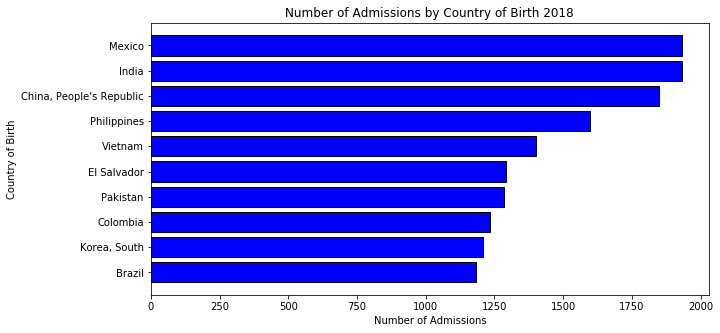

In [282]:
plt.figure(figsize = (10, 5))
plt.barh('Country of Birth', 'Admissions', data=top_10_by_country_2018, color = 'blue', edgecolor = 'black')
plt.gca().invert_yaxis()
plt.xlabel('Number of Admissions')
plt.ylabel('Country of Birth')
plt.title('Number of Admissions by Country of Birth 2018');
plt.show()

## looking at rows with admissions >2000

In [222]:
lpr_2018.loc[lpr_2018['Admissions'] >= 2000].head(15)

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year,Combined Class
772,California,Los Angeles,Mexico,Immediate Relatives - Parents,3662,2018,Immediate Relatives
784,California,Los Angeles,Mexico,Immediate Relatives - Spouses,4596,2018,Immediate Relatives
1522,Florida,Miami-Dade,Cuba,Refugee and Asylee Adjustments,31955,2018,Refugee and Asylee Adjustments
2377,New York,Queens,"China, People's Republic",Refugee and Asylee Adjustments,3041,2018,Refugee and Asylee Adjustments
4582,Texas,Harris,Cuba,Refugee and Asylee Adjustments,4009,2018,Refugee and Asylee Adjustments
4955,Texas,Harris,Mexico,Immediate Relatives - Spouses,2321,2018,Immediate Relatives
5995,Illinois,Cook,Mexico,Immediate Relatives - Spouses,2131,2018,Immediate Relatives
7491,New York,Bronx,Dominican Republic,Immediate Relatives - Spouses,2068,2018,Immediate Relatives
7496,New York,Bronx,Dominican Republic,Family Preference 2nd,4964,2018,Family Preference
8468,California,San Diego,Mexico,Immediate Relatives - Spouses,2735,2018,Immediate Relatives


In [263]:
lpr_2018['Combined Class'].value_counts().reset_index().head(10)

,index,Combined Class
0,Immediate Relatives,34453
1,Employment Preference,16671
2,Family Preference,15281
3,Refugee and Asylee Adjustments,6369
4,Diversity Program,4911
5,Other,1829


In [132]:
#lpr_2018.Admissions.sum()
lpr_2018.groupby('Combined Class').sum()

,Admissions,Year
Combined Class,,
Diversity Program,37157,9910398
Employment Preference,111796,33642078
Family Preference,182714,30837058
Immediate Relatives,382196,69526154
Other,27561,3690922
Refugee and Asylee Adjustments,162370,12852642


In [275]:
combined_class_2018 = lpr_2018.groupby(['Combined Class'])['Admissions'].sum()
combined_class_2018

Combined Class
Diversity Program                  37157
Employment Preference             111796
Family Preference                 182714
Immediate Relatives               382196
Other                              27561
Refugee and Asylee Adjustments    162370
Name: Admissions, dtype: int32

In [73]:
lpr_2018.Admissions.sum()

903794

In [75]:
print(lpr_2018.Admissions.mean())
print(lpr_2018.Admissions.median())

11.366476343788515
1.0


### Bar chart shows that the actual admission number of LPRs coming in as refugees/asylees is far higher than any other class of admission

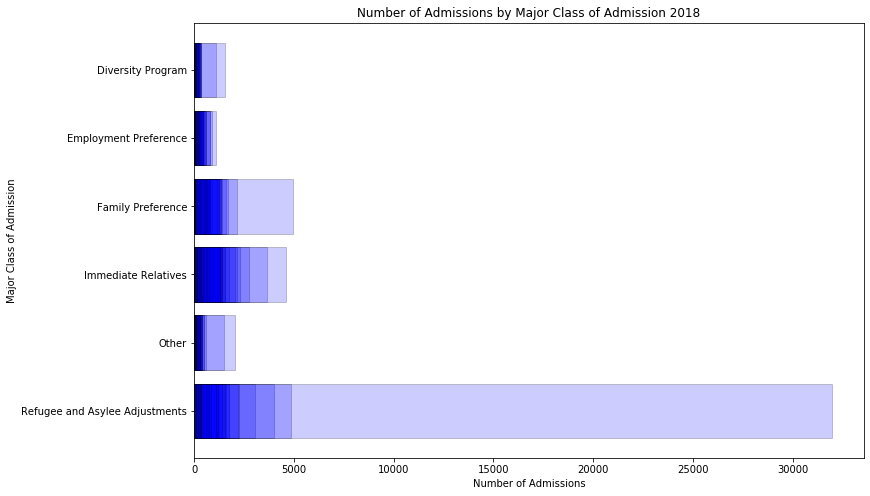

In [190]:
plt.figure(figsize = (12, 8))
plt.barh('Combined Class', 'Admissions', data=lpr_2018, color = 'blue', edgecolor = 'black', alpha = 0.2);
plt.xlabel('Number of Admissions')
plt.ylabel('Major Class of Admission')
plt.title('Number of Admissions by Major Class of Admission 2018');
plt.show()

### histogram shows most frequently counted Class of Admission as "immediate relatives," although the actual number of admissions of LPRs coming in as immediate relatives is far lower than refugees

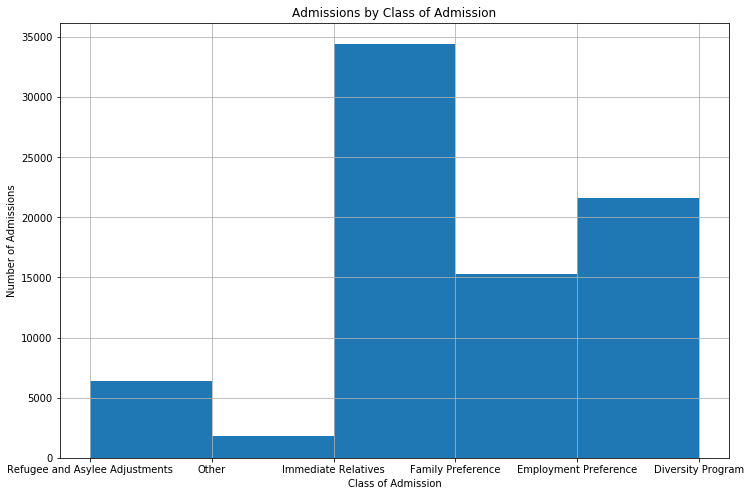

In [189]:
plt.figure(figsize = (12, 8))
lpr_2018['Combined Class'].hist(bins=5)
# #plt.xticks(rotation = 90)
plt.xlabel('Class of Admission')
plt.ylabel('Number of Admissions')
plt.title('Admissions by Class of Admission')
plt.show()

### how to get the actual numbers grouped to show what the bar chart shows?

In [68]:
lpr_2018_grouped = lpr_2018.groupby('Combined Class')['Admissions'].count().reset_index()
lpr_2018_grouped.head(6)
# total lines for file is 79514.  The numbers below add up to 79514, 
# but is not adding admissions, just showing there are more lines that say "Immediate Relatives" than "Refugee."
# The Relative lines have lower numbers (often D or <=3) than Refugee lines

,Combined Class,Admissions
0,Diversity Program,4911
1,Employment Preference,16671
2,Family Preference,15281
3,Immediate Relatives,34453
4,Other,1829
5,Refugee and Asylee Adjustments,6369


In [192]:
# this is not summing the refugee admissions column numbers -- one line alone has 34k, see earlier sorts
lpr_2018_grouped = lpr_2018.groupby('Combined Class')['Admissions'].sum().reset_index()
lpr_2018_grouped.head(6)

,Combined Class,Admissions
0,Diversity Program,37157
1,Employment Preference,111796
2,Family Preference,182714
3,Immediate Relatives,382196
4,Other,27561
5,Refugee and Asylee Adjustments,162370


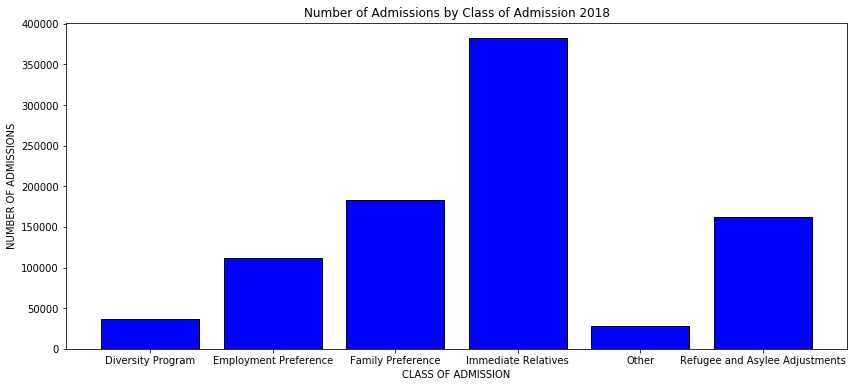

In [289]:
plt.figure(figsize = (14, 6))
plt.bar('Combined Class', 'Admissions', data=lpr_2018_grouped, color = 'blue', edgecolor = 'black')
#plt.gca().invert_yaxis()
plt.xlabel('CLASS OF ADMISSION')
plt.ylabel('NUMBER OF ADMISSIONS')
plt.title('Number of Admissions by Class of Admission 2018');
plt.show()

### repeat read-in on rest of files 2007-2017
- check head/tail on all to make sure no differences

In [11]:
lpr_2017= pd.read_excel('../data/lpr_usa_counties_2017_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2017.shape)
#lpr_2017.head()
lpr_2017.tail()

(80732, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
80727,Ohio,Montgomery,Vietnam,Immediate Relatives - Children,D
80728,Ohio,Montgomery,Vietnam,Immediate Relatives - Spouses,11
80729,Ohio,Montgomery,Vietnam,Family Preference 2nd,D
80730,Ohio,Montgomery,Vietnam,Immediate Relatives - Parents,7
80731,Ohio,Montgomery,Zimbabwe,Refugee and Asylee Adjustments,6


In [193]:
lpr_2017['Admissions'] = lpr_2017['Admissions'].replace(['D'], '1')
lpr_2017['Admissions'] = lpr_2017['Admissions'].astype(int)
lpr_2017['Year'] = 2017
lpr_2017.tail()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year
80727,Ohio,Montgomery,Vietnam,Immediate Relatives - Children,1,2017
80728,Ohio,Montgomery,Vietnam,Immediate Relatives - Spouses,11,2017
80729,Ohio,Montgomery,Vietnam,Family Preference 2nd,1,2017
80730,Ohio,Montgomery,Vietnam,Immediate Relatives - Parents,7,2017
80731,Ohio,Montgomery,Zimbabwe,Refugee and Asylee Adjustments,6,2017


In [195]:
lpr_2017.sort_values(by='Admissions',ascending = False).head()

,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions,Year
1531,Florida,Miami-Dade,Cuba,Refugee and Asylee Adjustments,27455,2017
771,California,Los Angeles,Mexico,Immediate Relatives - Spouses,6059,2017
6693,New York,Bronx,Dominican Republic,Family Preference 2nd,4819,2017
773,California,Los Angeles,Mexico,Immediate Relatives - Parents,3892,2017
17745,Florida,Hillsborough,Cuba,Refugee and Asylee Adjustments,3644,2017


In [13]:
lpr_2016 = pd.read_excel('../data/lpr_usa_counties_2016_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2016.shape)
#lpr_2016.head()
lpr_2016.tail()

(82103, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
82098,Washington,Spokane,Vietnam,Family Preference 3rd,7
82099,Washington,Spokane,Vietnam,Family Preference 2nd,D
82100,Washington,Spokane,Vietnam,Family Preference 1st,D
82101,Washington,Spokane,Yemen,Immediate Relatives - Spouses,D
82102,Washington,Spokane,Zambia,Immediate Relatives - Spouses,D


In [14]:
lpr_2015 = pd.read_excel('../data/lpr_usa_counties_2015_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2015.shape)
#lpr_2015.head()
lpr_2015.tail()

(77893, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
77888,Georgia,Clayton,Vietnam,Family Preference 3rd,41
77889,Georgia,Clayton,Vietnam,Family Preference 2nd,26
77890,Georgia,Clayton,Vietnam,Family Preference 1st,17
77891,Georgia,Clayton,Zambia,Immediate Relatives - Spouses,D
77892,Georgia,Clayton,Zimbabwe,Refugee and Asylee Adjustments,D


In [15]:
lpr_2014 = pd.read_excel('../data/lpr_usa_counties_2014_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2014.shape)
#lpr_2014.head()
lpr_2014.tail()

(79332, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
79327,Florida,Manatee,Vietnam,Family Preference 2nd,D
79328,Florida,Manatee,Vietnam,Family Preference 3rd,8
79329,Florida,Manatee,Vietnam,Employment Preference 2nd,D
79330,Florida,Manatee,Zimbabwe,Diversity Program,D
79331,Florida,Manatee,Zimbabwe,Employment Preference 1st,D


In [16]:
lpr_2013 = pd.read_excel('../data/lpr_usa_counties_2013_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2013.shape)
#lpr_2013.head()
lpr_2013.tail()

(80512, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
80507,New Jersey,Ocean,Vietnam,Immediate Relatives - Children,D
80508,New Jersey,Ocean,Vietnam,Immediate Relatives - Parents,6
80509,New Jersey,Ocean,Vietnam,Family Preference 4th,4
80510,New Jersey,Ocean,Vietnam,Family Preference 2nd,D
80511,New Jersey,Ocean,Yemen,Immediate Relatives - Spouses,D


In [17]:
lpr_2012 = pd.read_excel('../data/lpr_usa_counties_2012_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2012.shape)
#lpr_2012.head()
lpr_2012.tail()

(77324, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
77319,Texas,Galveston,Vietnam,Family Preference 4th,D
77320,Texas,Galveston,Vietnam,Family Preference 2nd,10
77321,Texas,Galveston,Vietnam,Family Preference 1st,D
77322,Texas,Galveston,Vietnam,Employment Preference 3rd Skilled,D
77323,Texas,Galveston,Zimbabwe,Immediate Relatives - Spouses,D


In [18]:
lpr_2011 = pd.read_excel('../data/lpr_usa_counties_2011_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2011.shape)
#lpr_2011.head()
lpr_2011.tail()

(79360, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
79355,New York,Oneida,Vietnam,Immediate Relatives - Children,D
79356,New York,Oneida,Vietnam,Immediate Relatives - Parents,D
79357,New York,Oneida,Vietnam,Family Preference 2nd,5
79358,New York,Oneida,Yemen,Immediate Relatives - Spouses,D
79359,New York,Oneida,Yemen,Immediate Relatives - Children,6


In [19]:
lpr_2010 = pd.read_excel('../data/lpr_usa_counties_2010_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2010.shape)
#lpr_2010.head()
lpr_2010.tail()

(80292, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
80287,Florida,Volusia,Vietnam,Immediate Relatives - Spouses,5
80288,Florida,Volusia,Vietnam,Immediate Relatives - Parents,6
80289,Florida,Volusia,Vietnam,Family Preference 4th,D
80290,Florida,Volusia,Vietnam,Family Preference 2nd,5
80291,Florida,Volusia,Zambia,Employment Preference 3rd Skilled,D


In [20]:
lpr_2009 = pd.read_excel('../data/lpr_usa_counties_2009_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2009.shape)
#lpr_2009.head()
lpr_2009.tail()

(81881, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
81876,Kentucky,Fayette,Vietnam,Immediate Relatives - Parents,D
81877,Kentucky,Fayette,Vietnam,Family Preference 1st,D
81878,Kentucky,Fayette,Zambia,Refugee and Asylee Adjustments,D
81879,Kentucky,Fayette,Zambia,Immediate Relatives - Spouses,D
81880,Kentucky,Fayette,Zimbabwe,Refugee and Asylee Adjustments,4


In [21]:
lpr_2008 = pd.read_excel('../data/lpr_usa_counties_2008_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2008.shape)
#lpr_2008.head()
lpr_2008.tail()

(81701, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
81696,California,Placer,Venezuela,Immediate Relatives - Parents,D
81697,California,Placer,Vietnam,Immediate Relatives - Spouses,D
81698,California,Placer,Vietnam,Immediate Relatives - Parents,5
81699,California,Placer,Vietnam,Family Preference 4th,D
81700,California,Placer,Vietnam,Family Preference 3rd,8


In [22]:
lpr_2007 = pd.read_excel('../data/lpr_usa_counties_2007_top_200.xlsx', skiprows=4, header=[0])
print(lpr_2007.shape)
#lpr_2007.head()
lpr_2007.tail()

(80222, 5)


,State of Residence,County of Residence,Country of Birth,Major Class of Admission,Admissions
80217,California,Sutter,United Kingdom,Immediate Relatives - Spouses,D
80218,California,Sutter,United Kingdom,Family Preference 4th,D
80219,California,Sutter,United Kingdom,Family Preference 2nd,D
80220,California,Sutter,Zambia,Employment Preference 3rd Skilled,D
80221,California,Sutter,Zimbabwe,Employment Preference 3rd Skilled,D


### add `Year` column to each file and fill with year
- check a few to make sure the fill worked properly

In [24]:
# lpr_2018['Year'] = 2018
# lpr_2017['Year'] = 2017
# lpr_2016['Year'] = 2016
# lpr_2015['Year'] = 2015
# lpr_2014['Year'] = 2014
# lpr_2013['Year'] = 2013
# lpr_2012['Year'] = 2012
# lpr_2011['Year'] = 2011
# lpr_2010['Year'] = 2010
# lpr_2009['Year'] = 2009
# lpr_2008['Year'] = 2008
# lpr_2007['Year'] = 2007
# lpr_2007.head()
# lpr_2017.head()
# lpr_2013.head()

### concat all LPR files 2007-2018 using list

In [28]:
#or use this example:
# dataframes = [lpr_2007, lpr_2008, lpr_2009, lpr_2010, lpr_2011, lpr_2012,
#               lpr_2013, lpr_2014, lpr_2015, lpr_2016, lpr_2017, lpr_2018]
# lpr_all = pd.concat(dataframes, axis=1).reset_index()
# lpr_all.head()

### replace D with 1, correct file type on merged file

In [ ]:
# lpr_all['Admissions'] = lpr_all['Admissions'].replace(['D'], '1')
# lpr_all['Admissions'] = lpr_all['Admissions'].astype(int)
# lpr_all.tail()

 ### save file to csv and export to data file

In [29]:
#lpr_all.to_csv('../data/lpr_all.csv')

### read in LPR adjustment file to look at data (don't think I'm using this file)

In [25]:
lpr_adjust = pd.read_excel('../data/lpr_adjustments_by_year_of_entry_2000_2018.xlsx', skiprows=1, header=[0], nrows=20)
print(lpr_adjust.shape)
lpr_adjust

(20, 25)


,Year of Adjustment,Total,1900 to 1980,1981 to 1990,1991 to 1995,1996 to 2000,2001,2002,2003,2004,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unknown
0,Total,229157,588,507,1358,20007,7759,7148,7205,12475,...,9326,9020,9049,9479,9661,9862,8725,3855,463,41761
1,2000,12694,3,10,278,6253,-,-,-,-,...,-,-,-,-,-,-,-,-,-,6150
2,2001,16421,8,15,193,5602,2057,-,-,-,...,-,-,-,-,-,-,-,-,-,8546
3,2002,14653,14,6,74,3356,1827,1665,-,-,...,-,-,-,-,-,-,-,-,-,7711
4,2003,7772,D,D,20,662,662,668,634,-,...,-,-,-,-,-,-,-,-,-,5120
5,2004,13175,9,6,41,983,1004,988,828,2362,...,-,-,-,-,-,-,-,-,-,6954
6,2005,19407,30,30,60,991,1104,2326,3057,4299,...,-,-,-,-,-,-,-,-,-,4381
7,2006,15204,74,74,134,585,332,562,1242,3192,...,-,-,-,-,-,-,-,-,-,1380
8,2007,13221,93,57,91,344,240,301,503,1074,...,-,-,-,-,-,-,-,-,-,549
9,2008,12672,67,43,86,293,152,238,348,587,...,-,-,-,-,-,-,-,-,-,227
